# Facial Expression Recognition

_Gabriella Mansur_

sources: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

### **Data description**

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

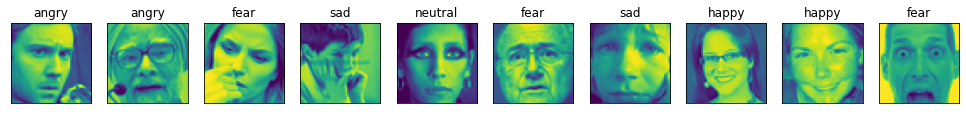

In [7]:
# How many images do you want to see?
n_images = 10

im_array = []

for i in range(n_images):
    array = df[' pixels'][i].split()
    array = np.asarray(array)
    array = array.astype(int)
    array = array.reshape(48,48)
    im_array.append(array)

im_array = np.array(im_array)

fig = plt.figure(figsize=(n_images*1.7,10))

for j in range(n_images):
    
    ax = fig.add_subplot(1, n_images, j+1)
    patch = im_array[j]
    ax.title.set_text(emotion_label[df['emotion'][j]])
    ax.imshow(patch)
    ax.set_xticks([])
    ax.set_yticks([])


train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.

The training set consists of 28,709 examples. The public test set used for the leaderboard consists of 3,589 examples. The final test set, which was used to determine the winner of the competition, consists of another 3,589 examples.

This dataset was prepared by Pierre-Luc Carrier and Aaron Courville, as part of an ongoing research project. They have graciously provided the workshop organizers with a preliminary version of their dataset to use for this contest.

### Libraries

In [1]:
# Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imshow, show   
%matplotlib inline
import keras
from PIL import Image
from numpy import eye  

from keras.models import Sequential 
from keras.layers import Dense, Activation, Convolution2D, Reshape, Flatten, MaxPooling2D, Dropout
from keras.utils import np_utils

### Load data

In [3]:
# Read datasets
df = pd.read_csv('icml_face_data.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### **EDA**

We'll do a soft exploration of the data to better understand what is going on. First we'll see the datasets that were given to us.

It looks like they have separated for us _the icml_face_data.csv_ into _train.csv_ and _test.csv_. See how the shapes add up.

In [4]:
# Shape of the datasets
print(df.shape)
print(train.shape)
print(test.shape)

(35887, 3)
(28709, 2)
(7178, 1)


In [5]:
# Peak into the datasets
print(df.head())
print(train.head())
print(test.head())

   emotion     Usage                                             pixels
0        0  Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  Training  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  Training  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                                              pixels
0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1  156 184 198 202 204 207 210 212 213 214 215 21...
2  69 118 61 60 96 121 103 87 103 88 

The emotions are as following:
0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

We will create a dictionary to relate each emotion number to its meaning.

In [6]:
# creating a dict file  
emotion_label = {0: 'angry', 
                 1: 'disgust', 
                 2: 'fear', 
                 3: 'happy', 
                 4: 'sad', 
                 5: 'surprise', 
                 6: 'neutral'}

From the distribution below, we can see the dataset is unbalanced, where class 1 (disgust) is underrepresented and class 3 (happy) is overrepresented. This means that our algorithm may, more often than for other emotions, give us false negatives for disgust emotions, and false positives for happy emotions.

Some possible solutions for this are to

(1) Collect more data for class 1

(2) Resample the dataset (oversample for class 1 and undersample for class 3, for instance)

(3) Use a penalizing model (penalize misclassifications from the minority class more than the majority)

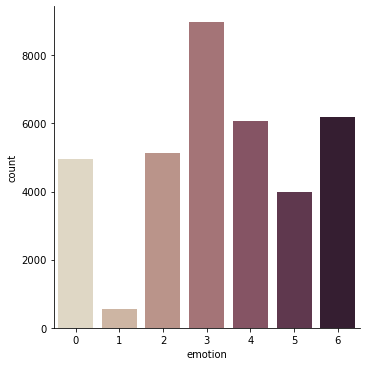

In [31]:
sns.catplot(x="emotion", kind="count", palette="ch:.3", data=df)

### Prepare Data

I'll choose to ignore the train/test datasets and make new ones from the icml_face_data from the "Usage" column. We'll use "PrivateTest" for validation and "PublicTest" for testing.

In [32]:
df[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

We'll create a function to preprocess the pixels and reshape them from (1, 48*48) to (1, 48, 48, 1). Remember this means (row, height, width, channels)

In [33]:
def preprocess_image(data):

    im_array = []
    im_label = []

    for i in range(len(data)):
        array = data[' pixels'][i].split()
        array = np.asarray(array)
        array = array.astype(int)
        array = array.reshape(48,48,1)
        im_array.append(array)

        label = data['emotion'][i]
        im_label.append(label)

    im_array = np.array(im_array)

    return im_array, im_label 

As I said earlier, I will create new dataframes for training, validation and testing, according to the "Usage" column, using the function I just created.

In [34]:
array_train, label_train = preprocess_image(df[df[' Usage'] == 'Training'].reset_index(drop=True))
array_val, label_val = preprocess_image(df[df[' Usage'] == 'PrivateTest'].reset_index(drop=True))
array_test, label_test = preprocess_image(df[df[' Usage'] == 'PublicTest'].reset_index(drop=True))

This gives us a train/val/test split of 80/10/10.

In [58]:
print('Train/val/test split:')
print('Training:', round(len(label_train)/len(df)*100,2), '%')
print('Training:', round(len(label_val)/len(df)*100,2), '%')
print('Training:', round(len(label_test)/len(df)*100,2), '%')

Train/val/test split:
Training: 80.0 %
Training: 10.0 %
Training: 10.0 %


### Choosing the model

For the model there are two possibilities:

1. Define our own CNN model
2. Use a model that was pre-trained on ImageNet and do transfer learning - for instance, VGG-16, Inception V3 or ResNet-50.

But because these pre-established models have fixed input shapes (e.g., 224x224) I was wondering if I could apply them to our case, where the images are 48x48. I found a good explanation here: https://www.pyimagesearch.com/2019/06/24/change-input-shape-dimensions-for-fine-tuning-with-keras/.

In short:

"There are limits to how much you can update the image dimensions, both from an **accuracy/loss perspective** and from **limitations of the network itself**.

![title](keras_input_shape_sizes.png)

Consider the fact that CNNs reduce volume dimensions via two methods:

1. Pooling (such as max-pooling in VGG16)
2. Strided convolutions (such as in ResNet)

If your input image dimensions are **too small** then the CNN will naturally reduce volume dimensions during the forward propagation and then effectively “run out” of data."

I will still try them and see for myself what happens.